In [1]:
import tensorflow

import pandas as pd
import numpy as np #데이터 배열화
import os #경로 설정용 
import keras #딥러닝용 패키지
import random #데이터 분산할 때 쓸 랜덤
import cv2 #이미지 읽기용
import math #연산용
import seaborn as sns #matplotlib에 다양한 시각화 기능이 추가된 패키지

from sklearn.metrics import confusion_matrix #분류의 정확성 평가
from sklearn.preprocessing import LabelBinarizer #데이터 전처리용
from sklearn.model_selection import train_test_split #데이터 분할용

import matplotlib.pyplot as plt #데이터 시각화용

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization #사용할 BN, ConV2 등의 계층
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout #사용할 레이어

from tensorflow.keras.applications import DenseNet121 #Densenet121 모델 사용
from tensorflow.keras.applications.densenet import preprocess_input #tensor나 numpy배열 전처리용

from tensorflow.keras.preprocessing import image #이미지 데이터를 실시간으로 처리하기 위한 도구
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array #이미지 편집을 위한 제너레이터(Affine Transform)

from tensorflow.keras.models import Model #교육 및 추론 기능이 있는 개체로 레이어를 그룹화

from tensorflow.keras.optimizers import Adam #Adam 옵티마이저 사용. loss는 categorical_crossentropy 사용

#체크포인트를 두고 저장 + metric이 중지되면 학습률을 감소
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

import warnings #경고 무시
warnings.filterwarnings("ignore")

In [2]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(48, 48, 3)) #채널이 무조건 3개여야 하며 크기는 최소 32 이상

x=model_d.output

x= GlobalAveragePooling2D()(x) #전역 평균 풀링 레이어 추가
x= BatchNormalization()(x) #배치 정규화 레이어
x= Dropout(0.3)(x)
#Fully Connected 레이어 추가
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.3)(x) #과적합 감소용 드롭아웃 레이어

preds=Dense(6,activation='softmax')(x) #FC-layer. 클래스가 7개이므로 softmax 7개 설정

In [3]:
model=Model(inputs=model_d.input,outputs=preds) 
model.summary() #모델 요약

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 24, 24, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [4]:
#Freeze
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [5]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy']) #모델 생성
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 24, 24, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv3_block6_1_conv (Conv2D)    (None, 6, 6, 128)    36864       conv3_block6_0_relu[0][0]        
__________________________________________________________________________________________________
conv3_block6_1_bn (BatchNormali (None, 6, 6, 128)    512         conv3_block6_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block6_1_relu (Activation (None, 6, 6, 128)    0           conv3_block6_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block6_2_conv (Conv2D)    (None, 6, 6, 32)     36864       conv3_block6_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block6_concat (Concatenat (None, 6, 6, 320)    0           conv3_block5_concat[0][0]        
                                                                 conv3_block6_2_conv[0][0]        
__________

In [6]:
data=[] #데이터
labels=[] #라벨
random.seed(42)
imagePaths = sorted(list(os.listdir("emotionHochan/"))) #데이터셋 경로
random.shuffle(imagePaths) #셔플
print(imagePaths)
#이미지 읽기 및 라벨링
for img in imagePaths:
    path=sorted(list(os.listdir("emotionHochan/"+img)))
    for i in path:
        image = cv2.imread("emotionHochan/"+img+'/'+i) #이미지 읽기
        image = cv2.resize(image, (48,48)) #이미지 사이즈 편집
        image = img_to_array(image) #이미지 배열화
        data.append(image) #data 배열에 데이터 추가
        l = label = img
        labels.append(l) #labels 배열에 데이터 추가

['neutral', 'fear', 'happy', 'sad', 'angry', 'surprise']


In [7]:
data = np.array(data, dtype="float32") / 255.0 #데이터 타입 변경 및 numpy 배열화
labels = np.array(labels) #라벨 numpy 배열화
mlb = LabelBinarizer() #데이터 전처리(원핫인코딩)
labels = mlb.fit_transform(labels) #데이터에 대해서 fit 작업과 transform 작업을 적용해주는 것
print(labels[0])

[0 0 0 1 0 0]


In [8]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.3,random_state=42) #train용과 test용으로 데이터셋 분리. test 30%
print(xtrain.shape, xtest.shape)

(44529, 48, 48, 3) (19084, 48, 48, 3)


In [9]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [10]:
#검증 손실에 변화가 없는 경우 학습률을 감소시켜 도움을 줌
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3) 
checkpoint = ModelCheckpoint('Densenet121_revised2.h5', verbose=1, save_best_only=True) #체크포인트를 두고 모델 저장

datagen = ImageDataGenerator(zoom_range = 0.3, horizontal_flip=True, shear_range=0.3) #이미지 가공(학습률 향상을 위한 augmentation)


datagen.fit(xtrain)
# 모델 학습
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=50,
               verbose=2,#verbose 2는 '세대 당 한 라인'을 의미
               callbacks=[anne, checkpoint], #학습과 검증 과정에서 적용할 콜백 리스트
               validation_data=(xtrain, ytrain)) #steps_per_epoch일 때 사용하는 것으로 샘플 배치 데이터 수

Epoch 1/50
347/347 - 61s - loss: 1.9688 - accuracy: 0.2958 - val_loss: 1.5755 - val_accuracy: 0.3802

Epoch 00001: val_loss improved from inf to 1.57551, saving model to Densenet121_revised2.h5
Epoch 2/50
347/347 - 48s - loss: 1.6931 - accuracy: 0.3370 - val_loss: 1.5745 - val_accuracy: 0.3825

Epoch 00002: val_loss improved from 1.57551 to 1.57453, saving model to Densenet121_revised2.h5
Epoch 3/50
347/347 - 47s - loss: 1.6340 - accuracy: 0.3491 - val_loss: 1.4820 - val_accuracy: 0.4132

Epoch 00003: val_loss improved from 1.57453 to 1.48197, saving model to Densenet121_revised2.h5
Epoch 4/50
347/347 - 48s - loss: 1.6002 - accuracy: 0.3630 - val_loss: 1.4744 - val_accuracy: 0.4154

Epoch 00004: val_loss improved from 1.48197 to 1.47442, saving model to Densenet121_revised2.h5
Epoch 5/50
347/347 - 48s - loss: 1.5771 - accuracy: 0.3789 - val_loss: 1.4738 - val_accuracy: 0.4222

Epoch 00005: val_loss improved from 1.47442 to 1.47382, saving model to Densenet121_revised2.h5
Epoch 6/50
347

Epoch 47/50
347/347 - 47s - loss: 1.3966 - accuracy: 0.4522 - val_loss: 1.2598 - val_accuracy: 0.5183

Epoch 00047: val_loss did not improve from 1.25176
Epoch 48/50
347/347 - 48s - loss: 1.3810 - accuracy: 0.4623 - val_loss: 1.2528 - val_accuracy: 0.5197

Epoch 00048: val_loss did not improve from 1.25176
Epoch 49/50
347/347 - 47s - loss: 1.3910 - accuracy: 0.4528 - val_loss: 1.2391 - val_accuracy: 0.5264

Epoch 00049: val_loss improved from 1.25176 to 1.23908, saving model to Densenet121_revised2.h5
Epoch 50/50
347/347 - 47s - loss: 1.3737 - accuracy: 0.4680 - val_loss: 1.2419 - val_accuracy: 0.5283

Epoch 00050: val_loss did not improve from 1.23908


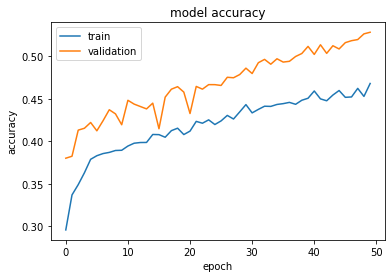

In [11]:
plot_hist(history)

In [12]:
#완성도 확인
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]): #가장 큰 값을 찾아 인덱스 반환
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 19084 	accurately-predicted-data: 9319 	 wrongly-predicted-data:  9765
Accuracy: 48.831 %


In [13]:
model.evaluate(xtest, ytest, batch_size = 32)

597/597 [==============================] - 17s 29ms/step - loss: 1.3228 - accuracy: 0.4883


[1.3227745294570923, 0.48831480741500854]